In [31]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size=16

train_dataloader = DataLoader(training_data, batch_size=16)
test_dataloader = DataLoader(test_data, batch_size=16)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.CNN_relu_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(0.3)
        )
        self.flatten = nn.Flatten()

        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 28, 28)
            dummy_output = self.CNN_relu_stack(dummy_input)
            flatten_dim = dummy_output.view(1, -1).shape[1]
            print(f'A= {flatten_dim}')

        self.classifier = nn.Sequential(
            nn.Linear(flatten_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)  # 10 output classes for FashionMNIST
        )

    def forward(self, x):

        x = self.CNN_relu_stack(x)
        x = self.flatten(x)
        logits = self.classifier(x)
        return logits

model = NeuralNetwork()

learning_rate = 1e-3
epochs = 20

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss() # Since, the output is more than 2 possible values, Cross Entropy was prefered.

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Using Stochastic Gradient Descent for optimising weights and biases after finding losses.


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # reinitialise gradient to 0

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

A= 1600
Epoch 1
-------------------------------
loss: 2.313417  [   16/60000]
loss: 2.291655  [ 1616/60000]
loss: 2.278991  [ 3216/60000]
loss: 2.313117  [ 4816/60000]
loss: 2.267166  [ 6416/60000]
loss: 2.270435  [ 8016/60000]
loss: 2.247584  [ 9616/60000]
loss: 2.209974  [11216/60000]
loss: 2.301935  [12816/60000]
loss: 2.281051  [14416/60000]
loss: 2.229752  [16016/60000]
loss: 2.217820  [17616/60000]
loss: 2.228741  [19216/60000]
loss: 2.213940  [20816/60000]
loss: 2.181146  [22416/60000]
loss: 2.119844  [24016/60000]
loss: 2.118382  [25616/60000]
loss: 2.151251  [27216/60000]
loss: 2.081959  [28816/60000]
loss: 2.049942  [30416/60000]
loss: 1.992893  [32016/60000]
loss: 1.868909  [33616/60000]
loss: 1.796808  [35216/60000]
loss: 1.863489  [36816/60000]
loss: 1.645763  [38416/60000]
loss: 1.703455  [40016/60000]
loss: 1.605142  [41616/60000]
loss: 1.547074  [43216/60000]
loss: 1.340320  [44816/60000]
loss: 1.420938  [46416/60000]
loss: 1.403705  [48016/60000]
loss: 1.347650  [49616

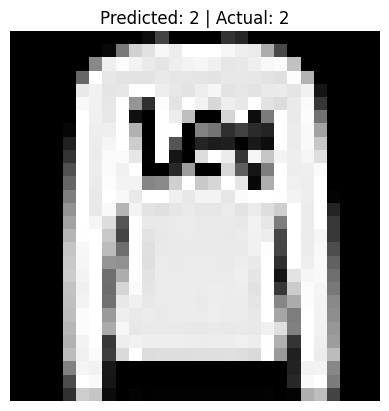

In [33]:
import matplotlib.pyplot as plt

# Get a single image and label from the test dataset
image, label = test_data[1]

# Add a batch dimension: [1, 1, 28, 28]
image_batch = image.unsqueeze(0)

# Set model to eval mode and get prediction
model.eval()
with torch.no_grad():
    output = model(image_batch)
    predicted_class = output.argmax(1).item()

# Show the image and prediction
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Predicted: {predicted_class} | Actual: {label}")
plt.axis("off")
plt.show()